In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage,ToolMessage, BaseMessage
from utils import available_pdfs
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import BaseTool, tool
from langgraph.prebuilt import ToolNode
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]
    pdf_query: list[str]

In [27]:
from utils import retriever

@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """
    available_pdfs = available_pdfs()
    
    retriever = retriever(pdfs = available_pdfs)

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

In [20]:
# Update tools list
tools = [retriever_tool]  # Use the properly decorated function

# Fix tools_dict
tools_dict = {tool.name: tool for tool in tools}

In [7]:
llm = ChatGroq(model = "llama-3.3-70b-versatile",max_tokens=16000)

In [47]:
from pydantic import BaseModel, Field
from typing import Literal

class Parser(BaseModel):
    """LLM will be allowed to output only 'summarization' or 'rag' based on the user query."""
    query: Literal["summarization", "rag"]
    pdfs: list[str] = Field(...,description="pdfs mentioned in the user query, if any")

def orchestrator(state: State) -> State:
    """Router function to determine the next step in the state graph.
    This function checks the current state and decides which tool or action to take next.

    Args:
        state (State): The current state of the graph.

    Returns:
        State: The updated state after processing the current step.
    """
    
    user_message = next((msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None)
    
    prompt = PromptTemplate(
    template="""
        You are a decision-making agent. Based on the user's query, you must select:

        1. <summarization> — Use this **only if** the user asks for a summary of the **entire PDF**.
        2. <rag> — Use this for **any other type of query**, such as questions about specific sections, topics, paragraphs, or details from the PDF.
        3. <pdfs> — Choose the **relevant PDF filenames** from the provided list that best match the user query. If none are relevant, return an **empty list**.

        Your response must include:
        - One tag: `<summarization>` or `<rag>`
        - A list of relevant PDFs in the `<pdfs>` tag

        Format:
        <decision>
        <pdfs>[list of relevant PDFs]</pdfs>

        User Query: {input}

        Available PDFs: {pdfs}
        """,
            input_variables=["input", "pdfs"],
        )
    
    structured_llm = llm.with_structured_output(Parser)
    
    chain = prompt | structured_llm
    
    messages = state["messages"]
    
    last_message = messages[-1] if messages else None
    
    pdfs = available_pdfs()
    response = chain.invoke({
        'input':last_message.content, 
        'pdfs': pdfs
                             })
    
    print(f"this is how the state looks like: {state["messages"] + [AIMessage(content=f"{response['messages'].content}")]}")
    
    return {"messages": state["messages"] + [AIMessage(content=f"{response['messages'].content}")]}

In [48]:
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain

def summarization(state: State) -> State:
    
    for pdf in state.get["pdfs",[]]:
        loader = PyPDFLoader(Path(pdf))
        docs = loader.load_and_split()
    
    split_docs = RecursiveCharacterTextSplitter(chunk_size = 15000, chunk_overlap=500).split_documents(docs)
    
    chain = load_summarize_chain(
        llm = llm,
        chain_type = "refine",
        verbose = False,
    )
    
    response = chain.invoke({"input_documents":split_docs}, return_only_outputs=True)
    
    print(f"this is how the state looks like: {state["messages"] + [AIMessage(content=response['output_text'])]}")
    
    return {"messages": state["messages"] + [AIMessage(content=response['output_text'])]}

In [49]:
def call_llm(state: State) -> State:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    system_prompt = """
        You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
        Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
        If you need to look up some information before asking a follow up question, you are allowed to do that!
        Please always cite the specific parts of the documents you use in your answers.
        """
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

In [50]:
def rag(state: State) -> State:
    """Execute tool calls from the LLM's response."""
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            
        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [51]:
def to_continue(state: State) -> State:
    """This function takes the output from router and decided what do no next."""
    messages = state["messages"]
    last_message = messages[-1]
    
    if isinstance(last_message, AIMessage):
        if last_message.content == "summarization":
            return "summarization"
        elif last_message.content == "rag":
            return "rag"
        else:
            raise ValueError(f"Unexpected content in last message: {last_message.content}")
           
def should_continue(state: State):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [52]:
memory = MemorySaver()

tool_node = ToolNode(tools = tools)

graph = StateGraph(State)

graph.add_node("router",orchestrator)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", rag)
graph.add_node("summarization_agent", summarization)
graph.add_node("tool", tool_node)


graph.add_edge(START, "router")
graph.add_conditional_edges(
    "router",
    to_continue,
    {
        "summarization": "summarization_agent",
        "rag": "llm"
    }
)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        True: "retriever_agent", 
        False: END}
)
graph.add_edge("retriever_agent", "llm")

app = graph.compile(checkpointer=memory)

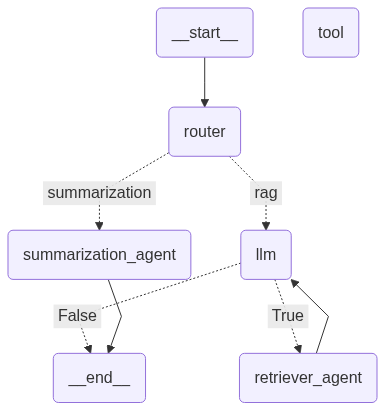

In [53]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [55]:
config = {"configurable": {"thread_id": "1"}}


user_input = "what is summary of the topic machine learning in the ai engineering pdf"

events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

# while True:
#     try:
#         user_input = input("User: ")
        
#         if user_input.lower() in ["exit", "quit", "stop"]:
#             break
#         events = app.stream(
#             {"messages": [{"role": "user", "content": user_input}]},
#             config,
#             stream_mode="values",
#         )
#         for event in events:
#             event["messages"][-1].pretty_print()
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         break

================================ Human Message =================================

what is summary of the topic machine learning in the ai engineering pdf


TypeError: 'Parser' object is not subscriptable